# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [1]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 30.1 MB/s eta 0:

In [2]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [4]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [7]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]
data_no_end = [s[:-1] for s in original_data]

Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 4, 1954, 256, 10, 8, 256, 7, 4, 52, 68, 3]
shuffled sentecen:  [2, 8, 256, 10, 1954, 4, 256, 4, 7, 68, 52, 3]


Let us look at detokenized data:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> the illinois river is a river in the united states <end>
shuffled sentence:  <start> a river is illinois the river the in states united <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test, d_train, d_test = train_test_split(original_data, shuffled_data, target_data, data_no_end, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [9]:
max_sequence_len = max([len(x) for x in original_data])
print("max_sequence_len: ", max_sequence_len)

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')
d_train = pad_sequences(d_train, maxlen=max_sequence_len, padding='post')
d_test = pad_sequences(d_test, maxlen=max_sequence_len, padding='post')

max_sequence_len:  32


In [9]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

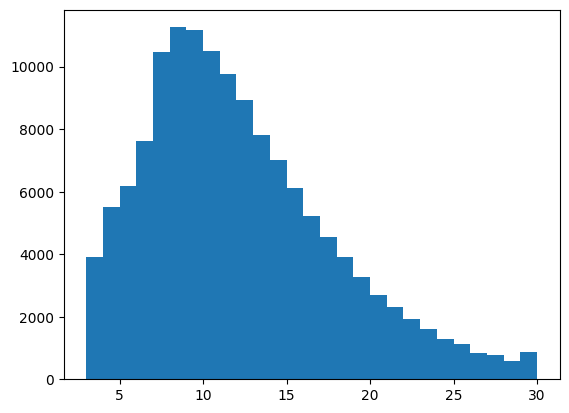

In [10]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [11]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/len(p))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 10K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

## Libraries
Installed keras_nlp and imported useful classes

In [10]:
!pip install keras-nlp --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 85.2 MB/s eta 0:00:00


In [11]:
from keras_nlp.layers import TransformerEncoder, TransformerDecoder,\
                              PositionEmbedding, TokenAndPositionEmbedding,\
                              SinePositionEncoding
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Data Augmentation
I will augment the training data performing more shuffling

In [ ]:
def data_augmentation(num_loop, x_train, c_train, y_train, sos, eos):
  # saving the input
  x_train_aug = x_train.copy()
  c_train_aug = c_train.copy()
  y_train_aug = y_train.copy()

  for _ in range(num_loop):
    # shuffle the data
    shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in x_train]
    shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
    # saving the augmented sets
    x_train_aug += x_train
    c_train_aug += shuffled_data
    y_train_aug += y_train

  return (x_train_aug, c_train_aug, y_train_aug)

In [ ]:
x_train_aug, c_train_aug, y_train_aug = data_augmentation(2, x_train, c_train, y_train, sos, eos)
print("x_train_aug size:", len(x_train_aug))
assert(len(x_train_aug)==len(c_train_aug)==len(y_train_aug))

x_train_aug size: 288330


In [ ]:
# results
i = np.random.randint(len(x_train_aug)/3)
print("original sentence: ",x_train_aug[i])
print("shuffled sentence 1: ",c_train_aug[i])
print("shuffled sentence 2: ",c_train_aug[i + len(x_train)])
print("shuffled sentence 3: ",c_train_aug[i + len(x_train)*2])

print('\n')
print("original sentence: ",tokenizer.sequences_to_texts([x_train_aug[i]])[0])
print("shuffled sentence 1: ",tokenizer.sequences_to_texts([c_train_aug[i]])[0])
print("shuffled sentence 2: ",tokenizer.sequences_to_texts([c_train_aug[i + len(x_train)]])[0])
print("shuffled sentence 3: ",tokenizer.sequences_to_texts([c_train_aug[i + len(x_train)*2]])[0])

original sentence:  [2, 1230, 53, 43, 216, 7, 4, 287, 66, 117, 64, 149, 3898, 3]
shuffled sentence 1:  [2, 149, 3898, 7, 53, 4, 43, 216, 66, 117, 64, 287, 1230, 3]
shuffled sentence 2:  [2, 1230, 7, 117, 216, 43, 3898, 287, 149, 64, 53, 66, 4, 3]
shuffled sentence 3:  [2, 64, 3898, 43, 287, 53, 216, 66, 1230, 7, 117, 149, 4, 3]


original sentence:  <start> chicago had first place in the 2018 time out city life index <end>
shuffled sentence 1:  <start> life index in had the first place time out city 2018 chicago <end>
shuffled sentence 2:  <start> chicago in out place first index 2018 life city had time the <end>
shuffled sentence 3:  <start> city index first 2018 had place time chicago in out life the <end>


## Defining the model


In [19]:
def get_model(num_layer, embedding_dim, feedforward_dim, num_heads, dropout, input_shape, vocabulary_dim=10000):
  input = Input(shape=input_shape)
  embedding_layer = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input)
  input2 = Input(shape=input_shape)
  embedding_layer2 = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input2)

  encoder = embedding_layer
  for _ in range(num_layer):
    encoder = TransformerEncoder(feedforward_dim, num_heads, dropout=dropout)(encoder)

  decoder = TransformerDecoder(feedforward_dim, num_heads, dropout=dropout)(encoder, encoder_sequence=embedding_layer2)
  for _ in range(num_layer-1):
    decoder = TransformerDecoder(feedforward_dim, num_heads, dropout=dropout)(decoder)

  output = Dense(vocabulary_dim)(decoder)

  model = Model([input, input2], output)
  model.summary()
  return model

In [38]:
def get_model(num_layer, embedding_dim, feedforward_dim, num_heads, dropout, input_shape, vocabulary_dim=10000):
  input = Input(shape=input_shape)
  embedding_layer = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input)
  input2 = Input(shape=input_shape)
  embedding_layer2 = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input2)

  encoder = embedding_layer
  for _ in range(num_layer):
    encoder = TransformerEncoder(feedforward_dim, num_heads, dropout=dropout)(encoder)

  decoder = TransformerDecoder(feedforward_dim, num_heads, dropout=dropout)(encoder, encoder_sequence=embedding_layer2)
  for _ in range(num_layer-1):
    decoder = TransformerDecoder(feedforward_dim, num_heads, dropout=dropout)(decoder)

  output = Dense(vocabulary_dim)(decoder)

  model = Model([input, input2], output)
  model.summary()
  return model

In [15]:
# def get_model(num_layer, embedding_dim, feedforward_dim, num_heads, dropout, input_shape, output_shape, vocabulary_dim=10000):
#   input = Input(shape=input_shape)
#   embedding_layer = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input)
#   input2 = Input(shape=input_shape-1)
#   embedding_layer2 = Embedding(input_dim=vocabulary_dim, output_dim=embedding_dim, mask_zero=True)(input2)

#   encoder = embedding_layer
#   for _ in range(num_layer):
#     encoder = TransformerEncoder(feedforward_dim, num_heads, dropout=dropout)(encoder)

#   decoder = TransformerDecoder(feedforward_dim, num_heads, dropout=dropout)(encoder, encoder_sequence=embedding_layer2)
#   for _ in range(num_layer-1):
#     decoder = TransformerDecoder(feedforward_dim, num_heads, dropout=dropout)(decoder)

#   output = Dense(output_shape)(decoder)

#   model = Model(input, output)
#   model.summary()
#   return model

In [39]:
d_model = 256

model = get_model(num_layer=4, embedding_dim=d_model, feedforward_dim=2048, \
                  num_heads=8, dropout=0.1, input_shape=(max_sequence_len,))

AttributeError: ignored

## Training

In [21]:
def display_history(history, accuracy_name):
    mse_training = history.history['loss']
    acc_training = history.history[accuracy_name]

    mse_val = history.history['val_loss']
    acc_val = history.history[f"val_{accuracy_name}"]

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

### Loss function, accuracy and optimizer

In [22]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
def my_loss(label, pred):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

def my_accuracy(label, pred):
  pass

In [23]:
!mkdir ckpts

In [27]:
learning_rate = CustomSchedule(d_model)
# optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer = Adam()


model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [28]:
epochs = 10
batch_size = 128
accuracy_name = "masked_accuracy"

earlyStopping = EarlyStopping(monitor = f"val_{accuracy_name}", mode = 'max', \
                              patience = 5, restore_best_weights = True)
modelCheckpoint = ModelCheckpoint('./ckpts/cp-{epoch:04d}.ckpt', monitor="val_loss", \
    save_best_only = True, save_weights_only = True, save_freq="epoch")

history = model.fit([c_train, d_train], y_train, validation_split=0.1, shuffle=True, \
                    epochs=epochs, batch_size=batch_size, \
                    callbacks=[earlyStopping, modelCheckpoint])

model.save_weights('weights.hdf5')

Epoch 1/10
676/676 [==============================] - 201s 249ms/step - loss: 6.7192 - masked_accuracy: 0.0784 - val_loss: 6.6766 - val_masked_accuracy: 0.0790
Epoch 2/10
676/676 [==============================] - 125s 184ms/step - loss: 6.6094 - masked_accuracy: 0.0925 - val_loss: 7.4605 - val_masked_accuracy: 0.0634
Epoch 3/10
676/676 [==============================] - 126s 186ms/step - loss: 6.5485 - masked_accuracy: 0.0991 - val_loss: 7.9500 - val_masked_accuracy: 0.0634
Epoch 4/10
676/676 [==============================] - 125s 185ms/step - loss: 6.5312 - masked_accuracy: 0.1004 - val_loss: 8.0196 - val_masked_accuracy: 0.0634
Epoch 5/10
676/676 [==============================] - 127s 188ms/step - loss: 6.5231 - masked_accuracy: 0.1007 - val_loss: 8.0224 - val_masked_accuracy: 0.0634
Epoch 6/10
676/676 [==============================] - 118s 174ms/step - loss: 6.5171 - masked_accuracy: 0.1011 - val_loss: 8.1004 - val_masked_accuracy: 0.0634


In [ ]:
display_history(history, "masked_accuracy")

In [ ]:
latest = tf.train.latest_checkpoint('ckpts')
model.load_weights(latest)

## Test

In [33]:
print("original_data", x_test[0])
print("shuffled_data", c_test[0])
print("target_data", y_test[0])
print("data_no_end", d_test[0])

# start_end = self.tokenizers.en.tokenize([''])[0]
# start = start_end[0][tf.newaxis]
# end = start_end[1][tf.newaxis]

# output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
# output_array = output_array.write(0,  [sos])

model.predict((c_test[1], d_test[1]))

original_data [   2    7 4570 1930   19  242  231  682    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
shuffled_data [   2  242   19 4570    7 1930  231  682    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
target_data [   7 4570 1930   19  242  231  682    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
data_no_end [   2    7 4570 1930   19  242  231  682    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


ValueError: ignored

In [ ]:
def test(labels, predictions):
  length = len(labels)
  assert(length == len(predictions))
  res = 0
  for i in range():
    res += score(labels[i], predictions[i])
  return res/length

def make_predictions(model, test_set):
  for x in test_set:
    model.predict(x)